<div><span style="background-color: #9e4244; padding-top: 80px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: white; font-size: 22px; font-weight: bold">Classification Model</span></div>

## Import Libraries

In [8]:
# General Libraries
import re
import time
import warnings
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
from scipy import stats
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Sklearn (machine learning)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score,f1_score, accuracy_score)
import sklearn.metrics as metrics

# Imblearn (resampling and pipeline)
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)

#from getml.predictors import XGBoostClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
# SHAP
# interpretability
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
import catboost as ctb

shap.initjs()
%load_ext autotime
# try:
#     %load_ext autotime
# except:
#     !pip install ipython-autotime
#     %load_ext autotime
#%unload_ext autotime


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 13.2 ms (started: 2022-12-14 10:50:48 +08:00)


## Dataset

In [16]:
df = pickle.load(open("dataset_classifier.pkl", "rb"))
display(df.head(), df.shape)

,hotel_name_,stars,review_rating_x,main_facilities,cheapest_price_x,link,facilities_count,nearest_other,number_close,zip_code,...,occupant,number_nights,price,total_price,ent_amenities,bathroom_keys,bedroom_keys,security_keys,service_amenties,other_amenities
0,RedDoorz near East Avenue Medical Center,2,6.0,"[Non Smoking Rooms, Free WiFi Internet Access ...",977.0,https://www.booking.com/hotel/ph/reddoorz-near...,22,0.9,21,1100,...,3,2,1590.0,3180.0,0,7,4,4,0,4
1,RedDoorz near East Avenue Medical Center,2,6.0,"[Non Smoking Rooms, Free WiFi Internet Access ...",977.0,https://www.booking.com/hotel/ph/reddoorz-near...,22,0.9,21,1100,...,1,6,977.0,5862.0,0,7,4,4,0,4
2,RedDoorz near East Avenue Medical Center,2,6.0,"[Non Smoking Rooms, Free WiFi Internet Access ...",977.0,https://www.booking.com/hotel/ph/reddoorz-near...,22,0.9,21,1100,...,3,1,1590.0,1590.0,0,7,4,4,0,4
3,RedDoorz near East Avenue Medical Center,2,6.0,"[Non Smoking Rooms, Free WiFi Internet Access ...",977.0,https://www.booking.com/hotel/ph/reddoorz-near...,22,0.9,21,1100,...,3,5,2308.0,11540.0,0,7,4,4,0,4
4,RedDoorz near East Avenue Medical Center,2,6.0,"[Non Smoking Rooms, Free WiFi Internet Access ...",977.0,https://www.booking.com/hotel/ph/reddoorz-near...,22,0.9,21,1100,...,3,2,2308.0,4616.0,0,7,4,4,0,4


(57030, 45)

time: 100 ms (started: 2022-12-14 10:53:08 +08:00)


## Data Cleaning

#### Remove Outliers

In [17]:
df_clean = df[(np.abs(stats.zscore(df['price'])) < 3)]

time: 53.9 ms (started: 2022-12-14 10:53:11 +08:00)


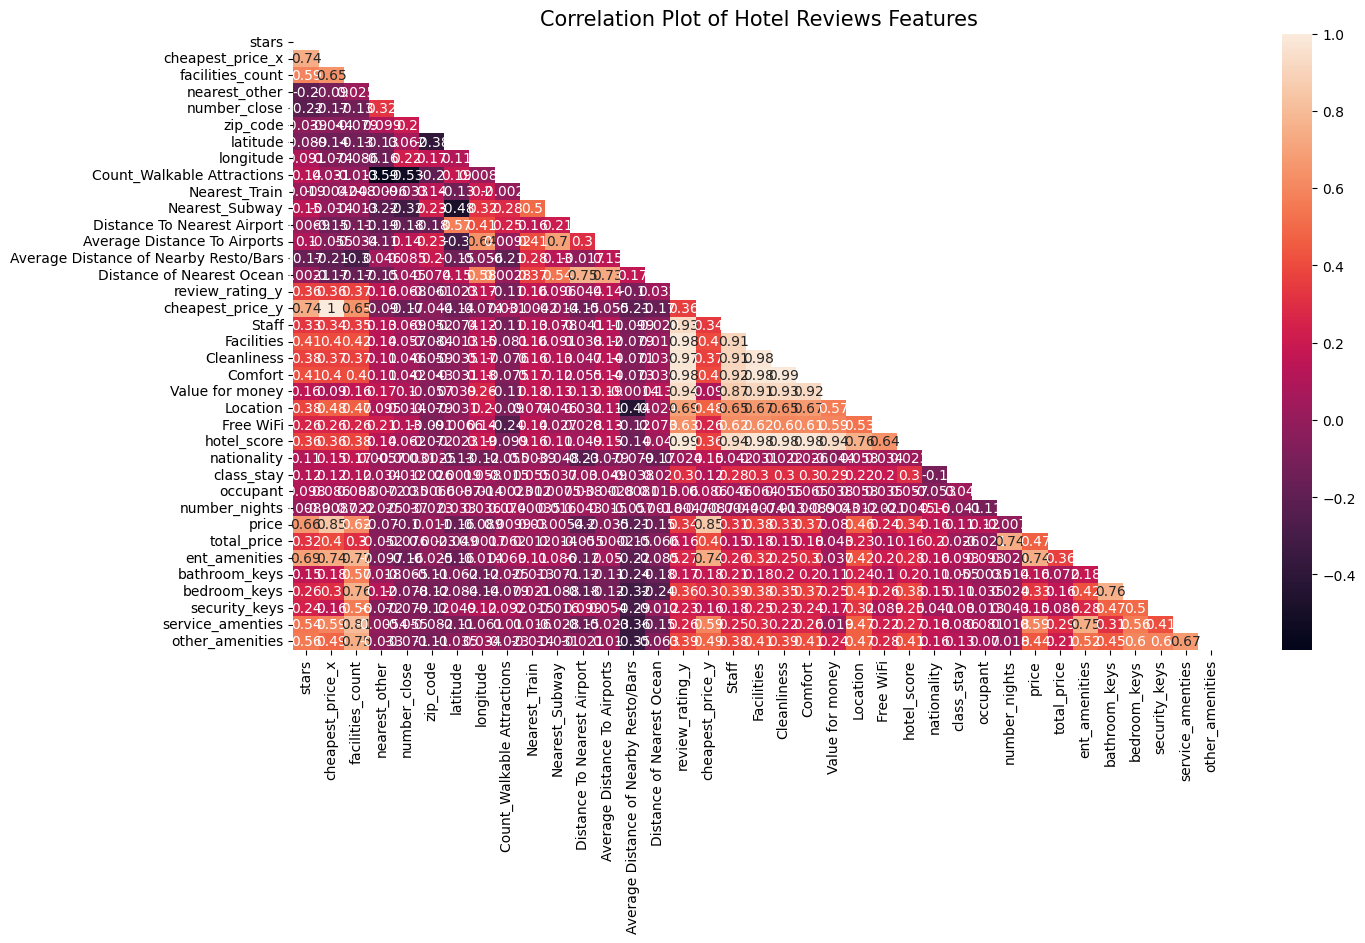

time: 2 s (started: 2022-12-14 10:53:13 +08:00)


In [18]:
quant = df_clean

corr = quant.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(corr, mask=mask, annot=True)
ax.set_title("Correlation Plot of Hotel Reviews Features", fontsize=15, y=1)
plt.show()

#### Remove Noise Features

In [23]:
df_final = df_clean.drop(['hotel_name_', 'review_rating_x', 'main_facilities', 'cheapest_price_x', 'link', 
                             'nearest_other', 'number_close', 'zip_code', 'review_rating_y', 'cheapest_price_y', 
                             'Staff', 'Facilities', 'Cleanliness', 'Comfort', 'Value for money',
                             'Location', 'Free WiFi', 'free_wifi_cat', 'hotel_score', 'year', 'month',
                             'facilities_count', 'Average Distance To Airports', 'city', 
                             'Nearest_Train', 'Distance of Nearest Ocean', 'Average Distance of Nearby Resto/Bars',
                             'Nearest_Subway', 'service_amenties'
                            ], axis = 1)

time: 5.47 ms (started: 2022-12-14 10:54:22 +08:00)


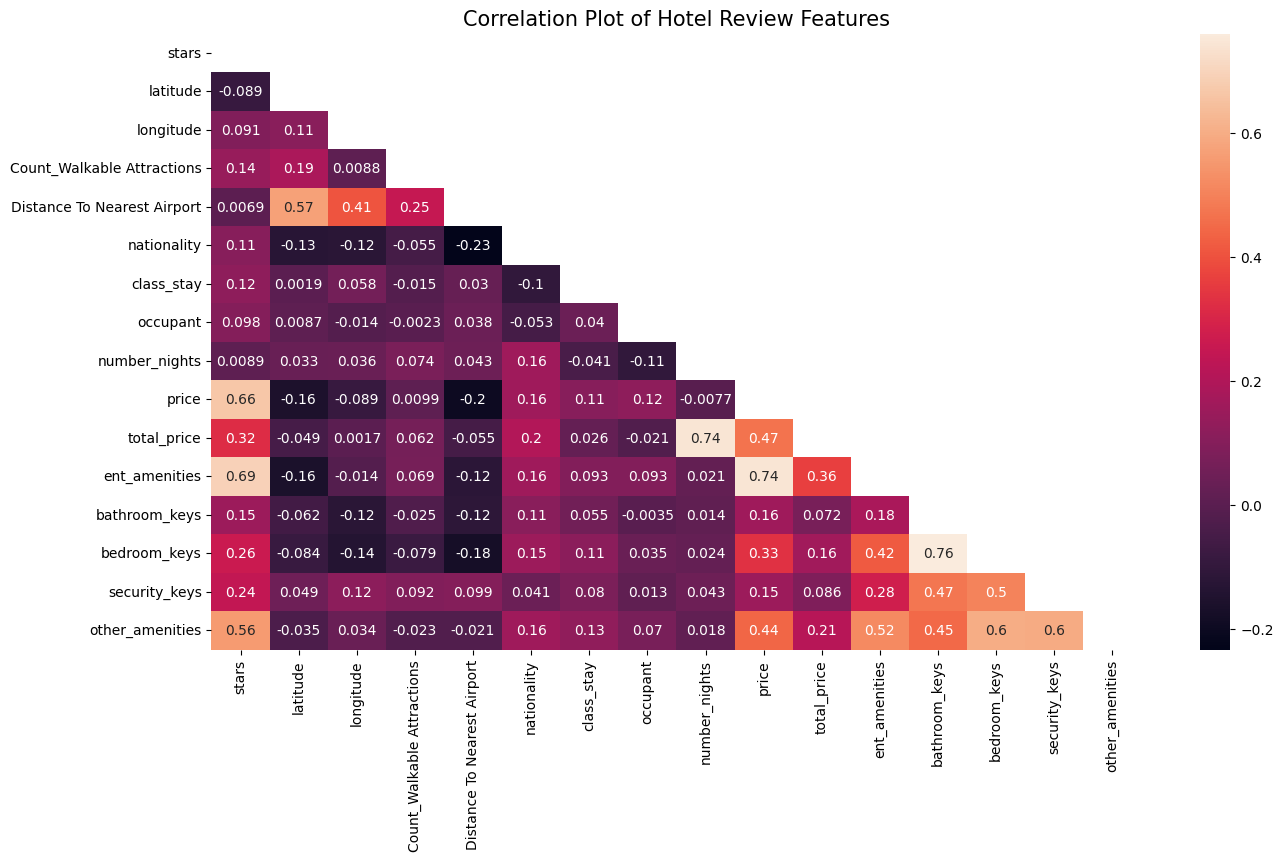

time: 571 ms (started: 2022-12-14 10:54:27 +08:00)


In [24]:
quant = df_final

corr = quant.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(corr, mask=mask, annot=True)
ax.set_title("Correlation Plot of Hotel Review Features", fontsize=15, y=1)
plt.show()

## Auto ML

In [25]:
X = df_final.drop(['class_stay'], axis=1)
y = df_final['class_stay']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                   test_size=0.25,
                                                                  stratify=y, random_state=42)

df_final.shape

(55343, 16)

time: 57.8 ms (started: 2022-12-14 10:55:06 +08:00)


#### Baselining

In [26]:
"""
    AUTOML Function
    Arguments: 
        X_trainval
        y_trainval
        models dictionary
        scaler = (MinMaxScaler, StandardScaler)
        cv (Cross Validation) = Kfolds, Traintestsplit, stratified
        res_t(Resampling) = ADASyn, Tomeklinks, etc.
    Returns:
        [0] = not formatted results
        [1] = formatted results (2decimals)
        [2] = model
"""
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {}
    results2 = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        train_scores = []
        val_scores = []

        train_precision = []
        val_precision = []
        val_prec_stdev=[]
        
        train_recall = []
        val_recall = []
        val_recall_stdev=[]
        
        train_f1 = []
        val_f1 = []
        val_f1_stdev=[]

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # precision
            train_precision.append(precision_score(y_train, train_preds))
            val_precision.append(precision_score(y_val, val_preds))
            
            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))
            
            # f1
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))

            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Precision': np.round(np.mean(train_precision) * 100, 2),
                'Val Precision': np.round(np.mean(val_precision) * 100, 2),
                'Val P.Std': np.round(np.std(val_precision) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Val R.Std': np.round(np.std(val_recall) * 100, 2),
                'Val F1': np.round(np.mean(val_recall) * 100, 2),
                'Val F1.Std': np.round(np.std(val_recall) * 100, 2),
                
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_precision)*100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_precision)*100, 2)),
                'Val P.Std': '{:.2f}%'.format(np.round(np.std(val_precision)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Val R.Std': '{:.2f}%'.format(np.round(np.std(val_recall)*100, 2)),
                'Val F1': '{:.2f}%'.format(np.round(np.mean(val_f1)*100, 2)),
                'Val F1.Std': '{:.2f}%'.format(np.round(np.std(val_f1)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2,model]


#-----------------------------------------------------------------------
def plot_scores(cv_scores_mean,cv_scores_std,metric):
    fig,axs = plt.subplots(1,2, figsize=(11,4))
    
    x = np.arange(len(cv_scores_mean))
    max_mean_score_idx = cv_scores_mean.argmax()
    
    axs[0].plot(x, cv_scores_mean, marker='.', lw=0)
    axs[0].plot(x[max_mean_score_idx],max(cv_scores_mean), marker="o", ms=7, color='r')
    axs[0].set_xlabel("Model config type")
    axs[0].set_ylabel("metric")

    axs[1].plot(x, cv_scores_std, marker='.', lw=0)
    axs[1].plot(x[max_mean_score_idx],cv_scores_std[max_mean_score_idx], marker="o", ms=7, color='r')
    axs[1].set_xlabel("Model config type")
    axs[1].set_ylabel(metric + " standard deviation")


def gridsearch(model,parameters,metric):
    Grid_model = GridSearchCV(estimator=model, param_grid = parameters, scoring=metric, cv = 5, n_jobs=-1,verbose=10)
    Grid_model.fit(X_trainval, y_trainval)


    #get scores
    cv_scores_mean =  Grid_model.cv_results_['mean_test_score']
    cv_scores_std = Grid_model.cv_results_['std_test_score']
    max_mean_score_idx = cv_scores_mean.argmax()

    print("")
    print("Best Estimator: {}".format(Grid_model.best_estimator_))
    print("Best Parameters: {}".format(Grid_model.best_params_))
    print('Best model CV config score is %f%% (vs. overall mean score: %f )' % (100*cv_scores_mean[max_mean_score_idx],
                                                                            100*np.mean(cv_scores_mean)))
    print('Std of best model score across folds is %f (vs. overall mean std: %f )' %\
          (cv_scores_std[max_mean_score_idx], np.mean(cv_scores_std)))

    # get best model
    model1 = Grid_model.best_estimator_
    # fit model for entire data
    model1.fit(X, y)
    pred1 = model1.predict(X)


    if metric=="accuracy":
        score = accuracy_score(y, pred1) * 100
    if metric=="recall":
        score = recall_score(y, pred1) * 100
    if metric=="precision":
        score = precision_score(y, pred1) * 100
    if metric=="f1":
        score = f1_score(y, pred1) * 100


    print('The %s of model for the full dataset is %f%%' % (metric,score))
    print('DONE!')
    
    print(" ")
    
    #print("Best Parameters: \n{}\n".format(Grid_model.best_params_))
    #print("Best Test Score: \n{}\n".format(Grid_model.best_score_))
    
    plot_scores(cv_scores_mean,cv_scores_std,metric)


time: 6.77 ms (started: 2022-12-14 10:55:20 +08:00)


In [ ]:
models_dict = {
    'XGBoostClassifier': xgb.XGBClassifier(n_jobs=-1),
    'KNeighborsClassifier': KNeighborsClassifier(n_jobs=-1),
    'LogisticRegressor': LogisticRegression(n_jobs=-1),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'CatBoostClassifier':ctb.CatBoostClassifier(#task_type="GPU",
                                                thread_count=-1,logging_level='Silent')
    
}

In [ ]:
auto_run = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
               cv=StratifiedKFold(n_splits=5))
auto = auto_run[0]
auto_run[1]

#### Gradient Boosting

In [28]:
spec_model = {"model": GradientBoostingClassifier()}

var = auto_ml(X_trainval, y_trainval, spec_model, scaler=MinMaxScaler(),
                cv=StratifiedKFold(n_splits=5), res_t=None)

model=var[2]

model.fit(X_trainval, y_trainval)
y_preds = (model.predict_proba(X_holdout)[:,1] >= 0.7).astype(bool)
a_holdout_score = accuracy_score(y_holdout, y_preds)
p_holdout_score = precision_score(y_holdout, y_preds)
r_holdout_score = recall_score(y_holdout, y_preds)
f1_holdout_score = f1_score(y_holdout, y_preds)

print("accuracy_score","precision_holdout,","recall_holdout,", "f1_holdout")
a_holdout_score,p_holdout_score,r_holdout_score,f1_holdout_score

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

accuracy_score precision_holdout, recall_holdout, f1_holdout


(0.5982220294882914,
 0.7871448532836516,
 0.5476344782890473,
 0.6459010128033633)

time: 18 s (started: 2022-12-14 10:59:35 +08:00)


6441

13836

'Took 46.55% of total trades'

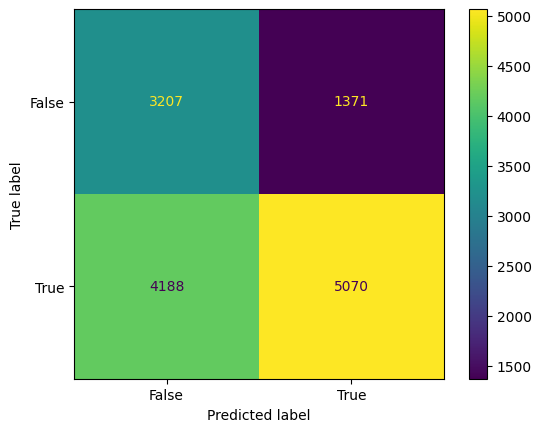

time: 179 ms (started: 2022-12-14 11:00:34 +08:00)


In [29]:
import sklearn.metrics as metrics
display(sum(y_preds),len(y_holdout))
display("Took {:0.2f}% of total trades". format(sum(y_preds)/len(y_holdout)*100))
confusion_matrix = metrics.confusion_matrix(y_holdout, y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

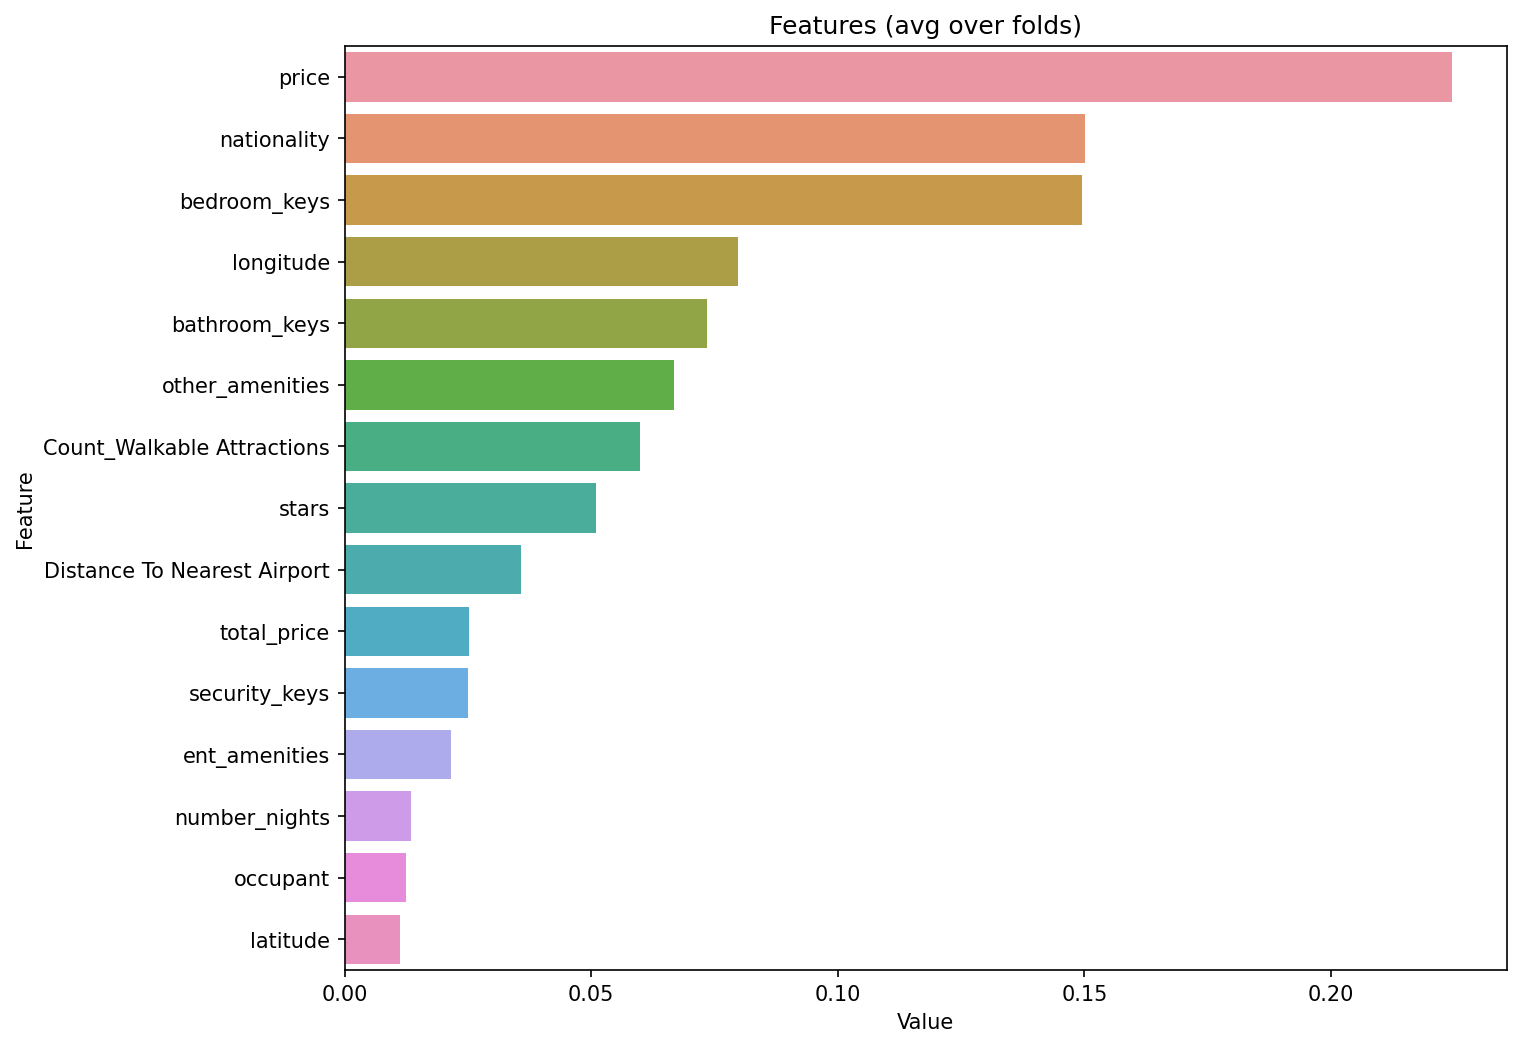

time: 340 ms (started: 2022-12-14 11:00:37 +08:00)


In [30]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_trainval.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 8), dpi=150)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(30))
#sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[-50:-30])
plt.title('Features (avg over folds)')
#plt.tight_layout()
plt.show()

## Explainability

In [31]:
explainer = shap.TreeExplainer(model, feature_names=X_holdout.columns)
shap_values_test = explainer.shap_values(X_holdout)

time: 891 ms (started: 2022-12-14 11:00:39 +08:00)


#### Global

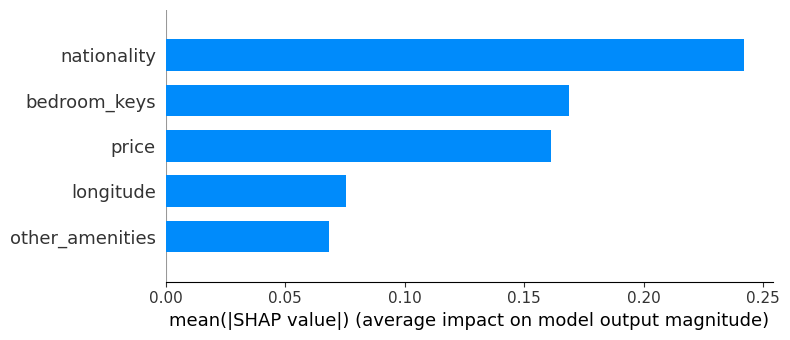

time: 150 ms (started: 2022-12-14 11:00:42 +08:00)


In [32]:
#shap.summary_plot(shap_values_test, X_holdout)
shap.summary_plot(shap_values_test, X_holdout, plot_type="bar", max_display=5)

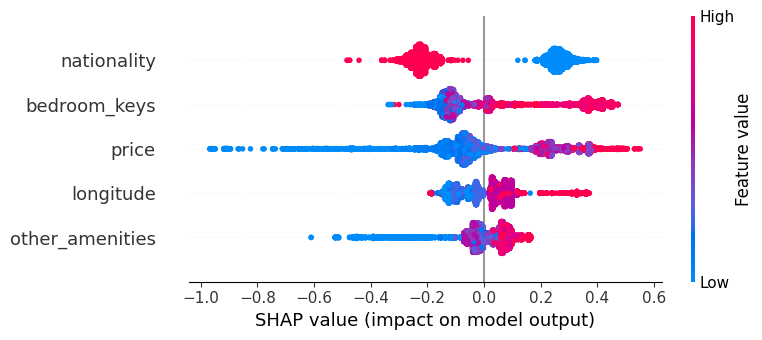

time: 634 ms (started: 2022-12-14 11:00:49 +08:00)


In [33]:
shap.summary_plot(shap_values_test, X_holdout, plot_type="dot", max_display = 5)

In [34]:
shap.force_plot(explainer.expected_value, shap_values_test[0,:], X_holdout.iloc[0,:])

time: 5.62 ms (started: 2022-12-14 11:00:57 +08:00)


#### Local

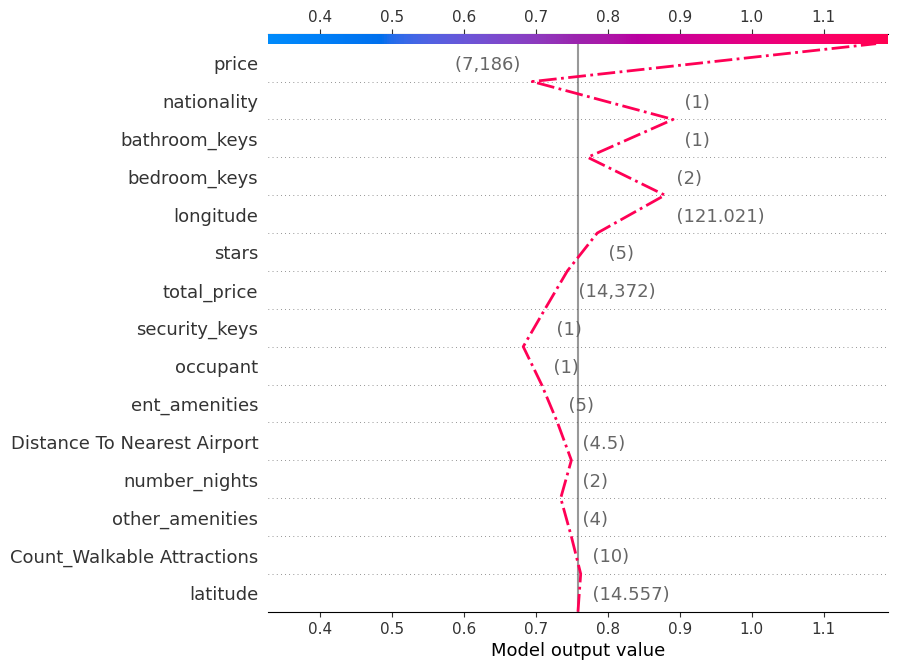

time: 371 ms (started: 2022-12-14 11:01:26 +08:00)


In [35]:
num=13045

expected_value = explainer.expected_value
shap.decision_plot(expected_value, shap_values_test[num],\
                   X_holdout.iloc[num], highlight=0)

In [36]:
display(X_holdout.iloc[[num]])
print("y_holdout actual- %s"  % (y_holdout.iloc[num]))
print("y_holdout pred- %s"  % (y_preds[num]))


,stars,latitude,longitude,Count_Walkable Attractions,Distance To Nearest Airport,nationality,occupant,number_nights,price,total_price,ent_amenities,bathroom_keys,bedroom_keys,security_keys,other_amenities
41468,5,14.556795,121.021123,10.0,4.5,1,1,2,7186.0,14372.0,5,1,2,1,4


y_holdout actual- 0
y_holdout pred- True
time: 12.9 ms (started: 2022-12-14 11:01:43 +08:00)


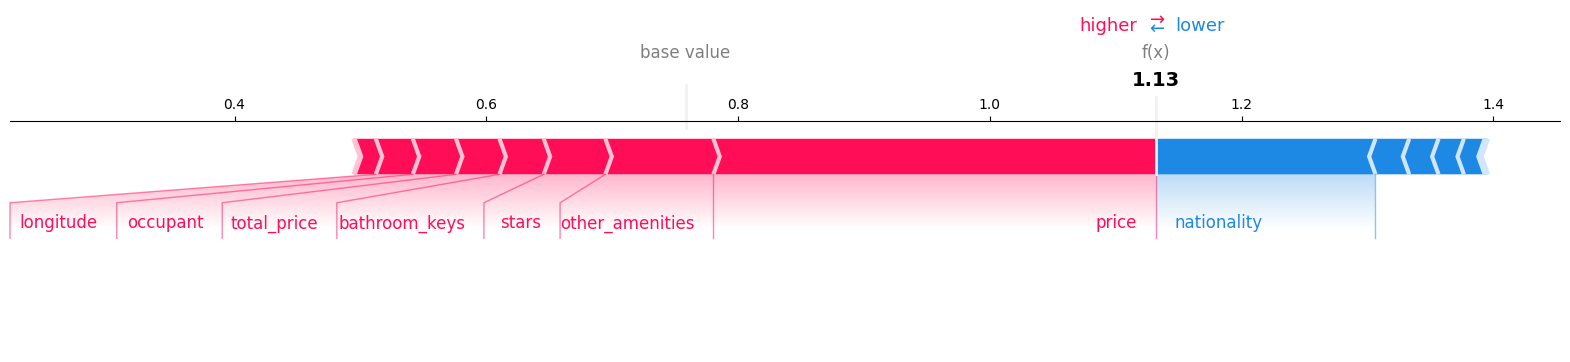

time: 941 ms (started: 2022-12-14 11:01:55 +08:00)


In [37]:
shap.force_plot(explainer.expected_value, 
                shap_values_test[2538], X_holdout.columns, matplotlib=True)

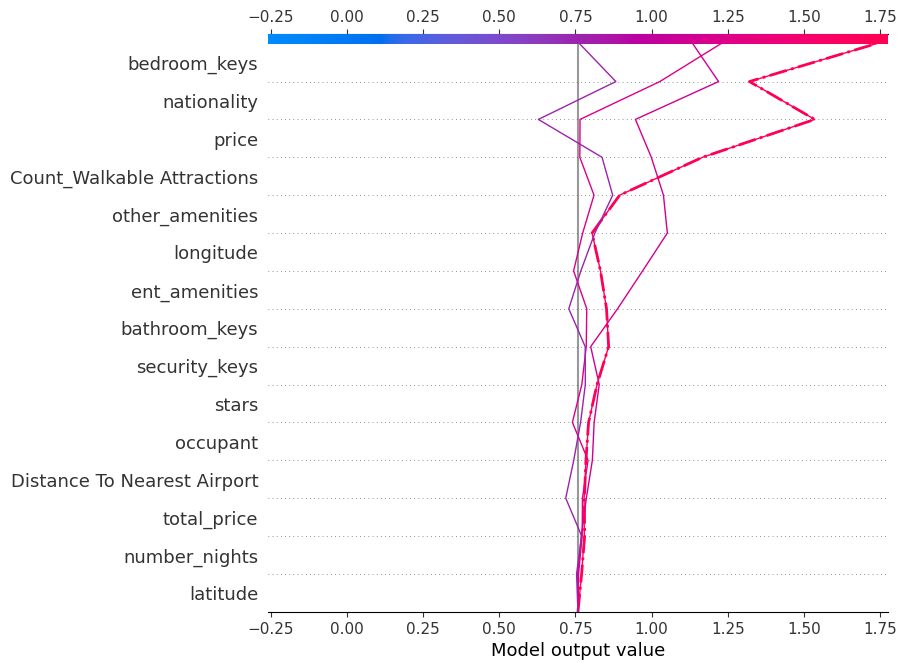

time: 366 ms (started: 2022-12-14 11:02:03 +08:00)


In [38]:
my_list=[7,13,19,30,32]
a=np.array(my_list)

shap.decision_plot(expected_value, shap_values_test[a],\
                   X_holdout.iloc[a], highlight=0)